In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
%matplotlib inline

In [2]:
def rescale(x):
    rx=(x-np.mean(x))/np.std(x)
    return rx

In [3]:
def assign_states(x,nstates):
    xs=np.sort(x)
    xstatestep=len(xs)/nstates
    xinterval=[0]
    for i in range(int(nstates/2-1)):
        xinterval=np.append(xinterval,xs[round(len(xs)/2)+(i+1)*round(xstatestep)])
    xinterval=np.append(xinterval,float('inf'))
    for j in range(int(nstates/2-1)):
        xinterval=np.append(xs[round(len(xs)/2)-(j+1)*round(xstatestep)],xinterval)
    xinterval=np.append(float('-inf'),xinterval)
    xstate=np.zeros(len(x))
    for i in range(len(x)):
        tempinterval=[]
        state=[]
        tempinterval=np.array(xinterval)
        tempinterval=np.append(tempinterval,x[i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==x[i])
        xstate[i]=state[0][0]
    xstate = xstate.astype(int)
    
    return xstate

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])
        MI[i]=np.sum(MIsingle)
    return timeshift,MI

In [6]:
def ConeOutput(x,phi):
    alpha_c=-9.602*10**-6
    beta_c=7*10**-3 #-1.148*10**-5
    alpha_h=2
    gamma=0.764
    tau_h=1.2
    tau_z=0.5769
    tau_y=0.056
    tau_c=0.05
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    # cone differential equation (include horizontal feedback)
#     phi=1
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    yh=np.zeros(len(x))
    for i in range(len(x)-1): # the length of kernel should be i, original length of kernel is len(Kh)
        dr=(alpha_c*y[i]-(1+beta_c*z[i])*(r[i]+phi*h[i]))*dt/tau_c
        dh=(alpha_h*r[i]-h[i])*dt/tau_h
        r[i+1]=r[i]+dr
        h[i+1]=h[i]+dh
    return r,h

In [7]:
# OU
Tot=100
dt=0.001
T=np.arange(dt,Tot,dt)
tau=0.5
D = 4
x=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    x[i+1]=x[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

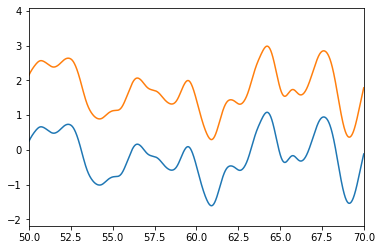

In [8]:
# filtering
fc=0.5
b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, x)
plt.plot(T,x)
plt.xlim(50,70)
x=x-min(x)
plt.plot(T,x)

In [9]:
# compare convolution and low pass differential equation
# dt=0.01
# tau_h=0.371
# Tk=np.arange(0,5,dt)
# Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
# htest=np.convolve(x,Kh,'full')
# htest=htest[0:len(x)]

# alpha_h=0.177
# tau_h2=1.5
# htest2=np.zeros(len(x))
# for i in range(len(x)-1):
#     dhtest2=(alpha_h*x[i]-htest2[i])*dt/tau_h2
#     htest2[i+1]=htest2[i]+dhtest2

# plt.plot(T,x/np.std(x))
# plt.plot(T,htest/np.std(htest))
# plt.plot(T,htest2/np.std(htest2))
# plt.xlim(40,60)

In [10]:
# two outputs with and without horizontal feedback
r,h=ConeOutput(x,1)
r_block,h_block=ConeOutput(x,0)

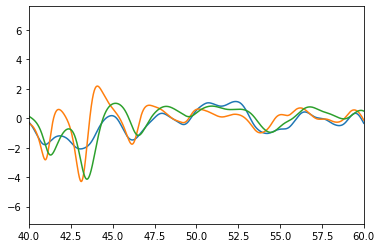

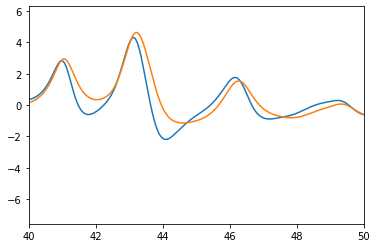

In [11]:
# plot different algorithm 
# plt.plot(T,r/np.std(r))
xr=rescale(x)
rr=rescale(r)
hr=rescale(h)
plt.plot(T,xr)
plt.plot(T,-rr)
plt.plot(T,-hr)
plt.xlim(40,60)
plt.show()

rbr=rescale(r_block)
hbr=rescale(h_block)
plt.plot(T,rr)
plt.plot(T,rbr)
plt.xlim(40,50)
plt.show()

In [12]:
# plt.plot(T,x/np.std(x))
# plt.plot(T,r/np.std(r))
# plt.plot(T,h/np.std(h))
# plt.legend(('x/$\sigma_x$', 'r/$\sigma_r$', 'h/$\sigma_h$'))
# plt.xlabel('time (s)')
# plt.xlim(40,60)
# plt.title('cone output with horizontal feedback')
# # plt.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/x-r.pdf')
# plt.show()

# plt.plot(T,x/np.std(x))
# plt.plot(T,r_block/np.std(r_block))
# plt.plot(T,h_block/np.std(h_block))
# plt.legend(('x/$\sigma_x$', 'r/$\sigma_r$', 'h/$\sigma_h$'))
# plt.xlabel('time (s)')
# plt.xlim(40,60)
# plt.title('cone output without horizontal feedback')
# # plt.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/x-r_block.pdf')
# plt.show()

In [13]:
xr_corr=signal.correlate(xr,rr,mode='same')
xr_block_xorr=signal.correlate(xr,rbr,mode='same')
abs_corr=xr_corr**2
abs_block_corr=xr_block_xorr**2

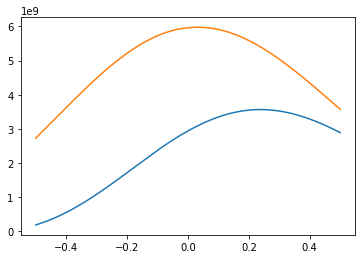

In [20]:
timeshift=np.arange(-0.5,0.5000001,dt)
maxstep=(len(timeshift)-1)/2
middle_index=(len(xr_corr)+1)/2
plt.plot(timeshift,abs_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])
plt.plot(timeshift,abs_block_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])
# plt.plot(timeshift,xr_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1])

In [15]:
# # plot again
# fig, ax1=plt.subplots(figsize=(8,6))
# c1 = 'tab:blue'
# ax1.set_xlabel('timeshift (s)', fontsize=20)
# ax1.set_ylabel('xcorr$^2$ of Cone cell output', fontsize=20,color=c1)
# ax1.plot(timeshift,abs_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1],color=c1)
# ax1.tick_params(axis='y',labelsize=16,labelcolor=c1)

# ax2 = ax1.twinx() 
# c2= 'tab:orange'
# ax2.set_xlabel('timeshift (s)', fontsize=20)
# ax2.set_ylabel('xcorr$^2$ of horizontal blocked Cone cell output', fontsize=20,color=c2)
# ax2.plot(timeshift,abs_block_corr[int(middle_index-maxstep):int(middle_index+maxstep)+1],color=c2)
# ax2.tick_params(axis='y',labelsize=16,labelcolor=c2)
# plt.show()

# # fig.savefig('F:/我的雲端硬碟/Retina exp/python code/Drinnenberg 2018/aaa.pdf')

In [16]:
x_state=EqualState(xr,8)
y_state=EqualState(rr,8)

In [17]:
TS,MI_H=MI(EqualState(xr,8),EqualState(rr,8),dt,[-3,3])
TS,MI_HB=MI(EqualState(xr,8),EqualState(rbr,8),dt,[-3,3])

KeyboardInterrupt: 

In [ ]:
plt.plot(TS,MI_H)
plt.plot(TS,MI_HB)